In [1]:
using Pkg
Pkg.activate("C:\\Users\\ignac\\neural_pde_env") 

  Activating project at `C:\Users\ignac\neural_pde_env`


**Imports**

In [2]:
using NeuralPDE
using Lux
using LuxCUDA          # GPU helper for Lux
using ComponentArrays
using ModelingToolkit
using DomainSets
using Optimization, OptimizationOptimisers
using Random
using Plots

**Define PDE symbolically**

In [3]:
@parameters x y
@variables u(..)

Dxx = Differential(x)^2
Dyy = Differential(y)^2

# Float32 version of π
π32 = Float32(pi)

# RHS of the Poisson equation: Δu = -sin(πx)sin(πy)
f(x, y) = -sin(π32 * x) * sin(π32 * y)

eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ f(x, y)

# Homogeneous Dirichlet boundaries
bcs = [
    u(0, y) ~ 0.0f0,
    u(1, y) ~ 0.0f0,
    u(x, 0) ~ 0.0f0,
    u(x, 1) ~ 0.0f0,
]

# Domain in Float32
domains = [
    x ∈ Interval(0.0f0, 1.0f0),
    y ∈ Interval(0.0f0, 1.0f0),
]

@named pde_system = PDESystem(eq, bcs, domains, [x, y], [u])

PDESystem
Equations: Equation[Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ -sin(3.1415927x)*sin(3.1415927y)]
Boundary Conditions: Equation[u(0, y) ~ 0.0, u(1, y) ~ 0.0, u(x, 0) ~ 0.0, u(x, 1) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0 .. 1.0), Symbolics.VarDomainPairing(y, 0.0 .. 1.0)]
Dependent Variables: Symbolics.CallWithMetadata{SymbolicUtils.FnType{Tuple, Real}, Base.ImmutableDict{DataType, Any}}[u⋆]
Independent Variables: Num[x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

**Lux neural network**

In [4]:
rng = Random.default_rng()
Random.seed!(rng, 0)

dim = 2          # x,y
width = 32

chain = Lux.Chain(
    Lux.Dense(dim => width, Lux.tanh),
    Lux.Dense(width => width, Lux.tanh),
    Lux.Dense(width => width, Lux.tanh),
    Lux.Dense(width => 1)
)

# Initialize Lux params (and ignore state, since Dense has none)
ps, st = Lux.setup(rng, chain)

# Make parameters Float32
ps = ps |> f32

(layer_1 = (weight = Float32[-1.8019577 1.5039126; -0.18273845 -1.5723097; … ; 1.8006785f-5 -1.17153; -0.12142389 0.28650352], bias = Float32[0.2490593, -0.4806301, 0.6780589, 0.0016063007, -0.522484, -0.6805993, -0.21060704, 0.50937545, 0.33639288, 0.22010256  …  -0.6673805, 0.12018823, 0.44865462, 0.19559266, 0.5209034, 0.38509727, -0.2188664, 0.61993414, -0.6848166, 0.44851506]), layer_2 = (weight = Float32[0.33954647 0.4428444 … -0.48383978 -0.49514067; 0.17026499 0.48028952 … 0.4932978 -0.0682411; … ; 0.30176318 -0.050574124 … 0.02281855 -0.041561913; -0.24699135 -0.2736988 … -0.07399511 0.19732474], bias = Float32[-0.13489445, -0.020966666, 0.16606493, -0.15410142, 0.15453151, -0.01737824, -0.09278538, 0.071856625, 0.0075518936, 0.05531519  …  -0.0028377052, -0.060067162, -0.13420774, -0.0015036942, -0.019579444, -0.03223136, 0.027485056, -0.022746634, -0.12287732, -0.01912546]), layer_3 = (weight = Float32[-0.4936314 -0.012550486 … -0.019880403 0.3814665; -0.4641115 0.24793701 …

**Put initial parameters on the GPU (this is the key step)**

In [5]:
# Move parameters to GPU as a ComponentArray (NeuralPDE expects this)
const gpud = gpu_device()          # from LuxCUDA
ps_gpu = ps |> ComponentArray |> gpud .|> Float32

ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:96, Axis(weight = ViewAxis(1:64, ShapedAxis((32, 2))), bias = ViewAxis(65:96, Shaped1DAxis((32,))))), layer_2 = ViewAxis(97:1152, Axis(weight = ViewAxis(1:1024, ShapedAxis((32, 32))), bias = ViewAxis(1025:1056, Shaped1DAxis((32,))))), layer_3 = ViewAxis(1153:2208, Axis(weight = ViewAxis(1:1024, ShapedAxis((32, 32))), bias = ViewAxis(1025:1056, Shaped1DAxis((32,))))), layer_4 = ViewAxis(2209:2241, Axis(weight = ViewAxis(1:32, ShapedAxis((1, 32))), bias = ViewAxis(33:33, Shaped1DAxis((1,))))))}}}(layer_1 = (weight = Float32[-1.8019577 1.5039126; -0.18273845 -1.5723097; … ; 1.8006785f-5 -1.17153; -0.12142389 0.28650352], bias = Float32[0.2490593, -0.4806301, 0.6780589, 0.0016063007, -0.522484, -0.6805993, -0.21060704, 0.50937545, 0.33639288, 0.22010256  …  -0.6673805, 0.12018823, 0.44865462, 0.19559266, 0.5209034, 0.38509727, -0.2188664, 0.61993414, -0.6848166, 0.44851506]), layer_2 = (weight

In [6]:
strategy = QuasiRandomTraining(200)   # 200 collocation points per batch

QuasiRandomTraining{QuasiMonteCarlo.LatinHypercubeSample}(200, 200, QuasiMonteCarlo.LatinHypercubeSample(TaskLocalRNG()), true, 0)

**Discretization (same API that solved the ODE)**

In [7]:
discretization = PhysicsInformedNN(
    chain,
    strategy;
    init_params = ps_gpu,   # start from GPU params
)

PhysicsInformedNN{Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_4::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}, QuasiRandomTraining{QuasiMonteCarlo.LatinHypercubeSample}, ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:96, Axis(weight = ViewAxis(1:64, ShapedAxis((32, 2))), bias = ViewAxis(65:96, Shaped1DAxis((32,))))), layer_2 = ViewAxis(97:1152, Axis(weight = ViewAxis(1:1024, ShapedAxis((32, 32))), bias = ViewAxis(1025:1056, Shaped1DAxis((32,))))), layer_3 = ViewAxis(1153:2208, Axis(weight = ViewAxis(1:1024, ShapedAxis((32, 32))), bias = ViewAxis(1025:1056, Shaped1DAxis((32,))))), layer_4 = ViewAxis(2209:2241, Axis(weight = ViewAxis(1:32, ShapedAxis((1, 32))), bias = ViewAxis(33:33, Shaped1DAxis((1,))

**Convert PDE into OptimizationProblem**

In [8]:
prob = NeuralPDE.discretize(pde_system, discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float32, CuArray{Float32, 1, CUDA.DeviceMemory}, Tuple{Axis{(layer_1 = ViewAxis(1:96, Axis(weight = ViewAxis(1:64, ShapedAxis((32, 2))), bias = ViewAxis(65:96, Shaped1DAxis((32,))))), layer_2 = ViewAxis(97:1152, Axis(weight = ViewAxis(1:1024, ShapedAxis((32, 32))), bias = ViewAxis(1025:1056, Shaped1DAxis((32,))))), layer_3 = ViewAxis(1153:2208, Axis(weight = ViewAxis(1:1024, ShapedAxis((32, 32))), bias = ViewAxis(1025:1056, Shaped1DAxis((32,))))), layer_4 = ViewAxis(2209:2241, Axis(weight = ViewAxis(1:32, ShapedAxis((1, 32))), bias = ViewAxis(33:33, Shaped1DAxis((1,))))))}}}(layer_1 = (weight = Float32[-1.8019577 1.5039126; -0.18273845 -1.5723097; … ; 1.8006785f-5 -1.17153; -0.12142389 0.28650352], bias = Float32[0.2490593, -0.4806301, 0.6780589, 0.0016063007, -0.522484, -0.6805993, -0.21060704, 0.50937545, 0.33639288, 0.22010256  …  -0.6673805, 0.12018823, 0.44865462, 0.19559266, 0.5209034, 0.38509727, -0.2188664, 0.61993414, -0.

**Train / Solve**

In [9]:
opt = OptimizationOptimisers.Adam(0.01f0)

callback = function (θ, loss)
    @info "loss = $(Float32(loss))"
    return false
end

t1 = time()
res = Optimization.solve(
    prob, 
    opt;
    maxiters = 3000,
    callback = callback
)

elapsed_time = (time() - t1)/60
println("Elapsed time: ", elapsed_time, " [min]")

[ Info: loss = 45.3207
[ Info: loss = 9.757187
[ Info: loss = 9.41548
[ Info: loss = 4.142133
[ Info: loss = 1.9114524
[ Info: loss = 1.3212011
[ Info: loss = 1.6879668
[ Info: loss = 2.1598728
[ Info: loss = 2.1505878
[ Info: loss = 1.3787318
[ Info: loss = 0.85295445
[ Info: loss = 0.72215253
[ Info: loss = 0.5222161
[ Info: loss = 0.5923623
[ Info: loss = 0.5355287
[ Info: loss = 0.5366604
[ Info: loss = 0.49595344
[ Info: loss = 0.40227094
[ Info: loss = 0.259555
[ Info: loss = 0.23424721
[ Info: loss = 0.14699431
[ Info: loss = 0.12135978
[ Info: loss = 0.13084035
[ Info: loss = 0.15662768
[ Info: loss = 0.16002664
[ Info: loss = 0.16221994
[ Info: loss = 0.16436884
[ Info: loss = 0.15944077
[ Info: loss = 0.13970228
[ Info: loss = 0.13103947
[ Info: loss = 0.1009536
[ Info: loss = 0.08543813
[ Info: loss = 0.06406996
[ Info: loss = 0.070231795
[ Info: loss = 0.056379735
[ Info: loss = 0.057451103
[ Info: loss = 0.05669056
[ Info: loss = 0.06452948
[ Info: loss = 0.058979232
[ Inf

[ Info: loss = 0.012480411
[ Info: loss = 0.012457284
[ Info: loss = 0.009355146
[ Info: loss = 0.01231082
[ Info: loss = 0.010982861
[ Info: loss = 0.01045459
[ Info: loss = 0.009684557
[ Info: loss = 0.009984467
[ Info: loss = 0.011166666
[ Info: loss = 0.010343093
[ Info: loss = 0.010245238
[ Info: loss = 0.01044923
[ Info: loss = 0.010507803
[ Info: loss = 0.011158188
[ Info: loss = 0.010159694
[ Info: loss = 0.009082312
[ Info: loss = 0.008998617
[ Info: loss = 0.0086380495
[ Info: loss = 0.009364392
[ Info: loss = 0.010329418
[ Info: loss = 0.009878032
[ Info: loss = 0.009005105
[ Info: loss = 0.0089862645
[ Info: loss = 0.008993004
[ Info: loss = 0.009229337
[ Info: loss = 0.009957633
[ Info: loss = 0.009182497
[ Info: loss = 0.008159444
[ Info: loss = 0.008221535
[ Info: loss = 0.008887708
[ Info: loss = 0.008203266
[ Info: loss = 0.008320521
[ Info: loss = 0.009193546
[ Info: loss = 0.008437168
[ Info: loss = 0.008241565
[ Info: loss = 0.008250982
[ Info: loss = 0.007682165
[ 

[ Info: loss = 0.0053478596
[ Info: loss = 0.0038211206
[ Info: loss = 0.0045373244
[ Info: loss = 0.004369331
[ Info: loss = 0.0050600767
[ Info: loss = 0.004299777
[ Info: loss = 0.004406042
[ Info: loss = 0.004311156
[ Info: loss = 0.004664031
[ Info: loss = 0.004439067
[ Info: loss = 0.0047247955
[ Info: loss = 0.0040628435
[ Info: loss = 0.00472846
[ Info: loss = 0.0044456157
[ Info: loss = 0.0045079286
[ Info: loss = 0.0052437754
[ Info: loss = 0.0044763107
[ Info: loss = 0.004258843
[ Info: loss = 0.0048779193
[ Info: loss = 0.004321125
[ Info: loss = 0.004299389
[ Info: loss = 0.004174402
[ Info: loss = 0.004225962
[ Info: loss = 0.0046886792
[ Info: loss = 0.004028418
[ Info: loss = 0.003790295
[ Info: loss = 0.003486265
[ Info: loss = 0.0040442874
[ Info: loss = 0.0041295597
[ Info: loss = 0.004556775
[ Info: loss = 0.0047265766
[ Info: loss = 0.0037669232
[ Info: loss = 0.0040862346
[ Info: loss = 0.0037343847
[ Info: loss = 0.0037087025
[ Info: loss = 0.0033930112
[ Info: l

[ Info: loss = 0.0026015847
[ Info: loss = 0.0022884733
[ Info: loss = 0.0026241776
[ Info: loss = 0.0027552177
[ Info: loss = 0.0025177614
[ Info: loss = 0.0026128404
[ Info: loss = 0.0023961067
[ Info: loss = 0.0025282488
[ Info: loss = 0.0028814278
[ Info: loss = 0.0026760306
[ Info: loss = 0.0021450487
[ Info: loss = 0.0024851263
[ Info: loss = 0.0025977958
[ Info: loss = 0.0025176632
[ Info: loss = 0.0024617254
[ Info: loss = 0.0023334008
[ Info: loss = 0.0024154517
[ Info: loss = 0.002238821
[ Info: loss = 0.00229639
[ Info: loss = 0.002265744
[ Info: loss = 0.0021662975
[ Info: loss = 0.0024754186
[ Info: loss = 0.0023418695
[ Info: loss = 0.0025994168
[ Info: loss = 0.0025158837
[ Info: loss = 0.002320382
[ Info: loss = 0.0022242907
[ Info: loss = 0.0020064171
[ Info: loss = 0.0022228195
[ Info: loss = 0.0024650658
[ Info: loss = 0.002674439
[ Info: loss = 0.0025964854
[ Info: loss = 0.002359822
[ Info: loss = 0.0022398364
[ Info: loss = 0.001849874
[ Info: loss = 0.002024345
[

[ Info: loss = 0.0015548152
[ Info: loss = 0.0014972945
[ Info: loss = 0.0017199172
[ Info: loss = 0.0015385792
[ Info: loss = 0.0014987625
[ Info: loss = 0.0012848726
[ Info: loss = 0.0015937686
[ Info: loss = 0.0016228904
[ Info: loss = 0.0017500955
[ Info: loss = 0.0016359848
[ Info: loss = 0.0015160748
[ Info: loss = 0.0016919798
[ Info: loss = 0.001580593
[ Info: loss = 0.0014540994
[ Info: loss = 0.0017960422
[ Info: loss = 0.001568412
[ Info: loss = 0.0015866782
[ Info: loss = 0.0014756331
[ Info: loss = 0.0015690932
[ Info: loss = 0.0015730114
[ Info: loss = 0.0015282694
[ Info: loss = 0.0014169867
[ Info: loss = 0.0015978803
[ Info: loss = 0.0013639133
[ Info: loss = 0.0014538253
[ Info: loss = 0.0013899698
[ Info: loss = 0.001491661
[ Info: loss = 0.0014507793
[ Info: loss = 0.0015441155
[ Info: loss = 0.0014548311
[ Info: loss = 0.0014962119
[ Info: loss = 0.0015680306
[ Info: loss = 0.0014597552
[ Info: loss = 0.0016669058
[ Info: loss = 0.0013456815
[ Info: loss = 0.001372

[ Info: loss = 0.0010745825
[ Info: loss = 0.0011059185
[ Info: loss = 0.0011092776
[ Info: loss = 0.0010370068
[ Info: loss = 0.0010922991
[ Info: loss = 0.0011506298
[ Info: loss = 0.0012324731
[ Info: loss = 0.0010251777
[ Info: loss = 0.0010601226
[ Info: loss = 0.0010568246
[ Info: loss = 0.0011850308
[ Info: loss = 0.0011356263
[ Info: loss = 0.0011237818
[ Info: loss = 0.0011128036
[ Info: loss = 0.00115223
[ Info: loss = 0.001147341
[ Info: loss = 0.0011034491
[ Info: loss = 0.0011349963
[ Info: loss = 0.0011563279
[ Info: loss = 0.0010743276
[ Info: loss = 0.0011463141
[ Info: loss = 0.00093008386
[ Info: loss = 0.0011478635
[ Info: loss = 0.0009812335
[ Info: loss = 0.0011493664
[ Info: loss = 0.0010296172
[ Info: loss = 0.001027763
[ Info: loss = 0.0011560288
[ Info: loss = 0.00096754637
[ Info: loss = 0.0009474466
[ Info: loss = 0.0011139611
[ Info: loss = 0.00095639133
[ Info: loss = 0.001074737
[ Info: loss = 0.0011331494
[ Info: loss = 0.0010051272
[ Info: loss = 0.00093

[ Info: loss = 0.0010047002
[ Info: loss = 0.0007434387
[ Info: loss = 0.0008061513
[ Info: loss = 0.00086296373
[ Info: loss = 0.0007998545
[ Info: loss = 0.00090724847
[ Info: loss = 0.00078436395
[ Info: loss = 0.00080546626
[ Info: loss = 0.00089872524
[ Info: loss = 0.0007812673
[ Info: loss = 0.00078735355
[ Info: loss = 0.00072720717
[ Info: loss = 0.0008848772
[ Info: loss = 0.0007643442
[ Info: loss = 0.0007552344
[ Info: loss = 0.00078265707
[ Info: loss = 0.00078538305
[ Info: loss = 0.0007286679
[ Info: loss = 0.00091914274
[ Info: loss = 0.00080463174
[ Info: loss = 0.00086223223
[ Info: loss = 0.0006924978
[ Info: loss = 0.00082582346
[ Info: loss = 0.0008015915
[ Info: loss = 0.0007194823
[ Info: loss = 0.0007849978
[ Info: loss = 0.00076769467
[ Info: loss = 0.00085863704
[ Info: loss = 0.00082737656
[ Info: loss = 0.0008477064
[ Info: loss = 0.00083119015
[ Info: loss = 0.00069074763
[ Info: loss = 0.00071806146
[ Info: loss = 0.00072507764
[ Info: loss = 0.00083354564

[ Info: loss = 0.0007560102
[ Info: loss = 0.0006193014
[ Info: loss = 0.0007084415
[ Info: loss = 0.000593279
[ Info: loss = 0.0006500118
[ Info: loss = 0.0006645216
[ Info: loss = 0.00062453013
[ Info: loss = 0.0007364325
[ Info: loss = 0.0005500482
[ Info: loss = 0.000673439
[ Info: loss = 0.00066001905
[ Info: loss = 0.0006140243
[ Info: loss = 0.0006335194
[ Info: loss = 0.00071530556
[ Info: loss = 0.00059915485
[ Info: loss = 0.0006045848
[ Info: loss = 0.000640889
[ Info: loss = 0.0006353274
[ Info: loss = 0.00062973483
[ Info: loss = 0.0006328685
[ Info: loss = 0.0005948355
[ Info: loss = 0.0005587984
[ Info: loss = 0.0005411863
[ Info: loss = 0.0005708703
[ Info: loss = 0.0006331583
[ Info: loss = 0.0005181447
[ Info: loss = 0.0005759089
[ Info: loss = 0.00057557446
[ Info: loss = 0.0005608044
[ Info: loss = 0.00048190315
[ Info: loss = 0.00061395025
[ Info: loss = 0.000506841
[ Info: loss = 0.00058948447
[ Info: loss = 0.0005833772
[ Info: loss = 0.0005704417
[ Info: loss = 

[ Info: loss = 0.00047249394
[ Info: loss = 0.0005737614
[ Info: loss = 0.00048351445
[ Info: loss = 0.000568994
[ Info: loss = 0.00045296224
[ Info: loss = 0.0005457648
[ Info: loss = 0.0005802298
[ Info: loss = 0.00053271954
[ Info: loss = 0.0005489652
[ Info: loss = 0.00057686015
[ Info: loss = 0.00045111202
[ Info: loss = 0.00057003926
[ Info: loss = 0.0004836322
[ Info: loss = 0.0004870816
[ Info: loss = 0.0006259396
[ Info: loss = 0.0005837366
[ Info: loss = 0.0005109123
[ Info: loss = 0.0005832484
[ Info: loss = 0.0005542793
[ Info: loss = 0.0005629632
[ Info: loss = 0.0005329016
[ Info: loss = 0.0005880856
[ Info: loss = 0.00053469243
[ Info: loss = 0.0005163138
[ Info: loss = 0.0005662687
[ Info: loss = 0.00055653416
[ Info: loss = 0.00052504335
[ Info: loss = 0.0005394829
[ Info: loss = 0.00047796883
[ Info: loss = 0.0005127189
[ Info: loss = 0.0005788106
[ Info: loss = 0.00042445824
[ Info: loss = 0.0005982805
[ Info: loss = 0.00051998935
[ Info: loss = 0.00048376084
[ Info:

[ Info: loss = 0.00039820693
[ Info: loss = 0.00041349613
[ Info: loss = 0.00042303634
[ Info: loss = 0.0005034988
[ Info: loss = 0.00040331983
[ Info: loss = 0.00041193946
[ Info: loss = 0.00042352467
[ Info: loss = 0.0004104505
[ Info: loss = 0.0004439322
[ Info: loss = 0.00041442353
[ Info: loss = 0.00039670937
[ Info: loss = 0.00040291017
[ Info: loss = 0.00040928583
[ Info: loss = 0.00041509615
[ Info: loss = 0.00034635834
[ Info: loss = 0.00039576343
[ Info: loss = 0.00041164242
[ Info: loss = 0.00040087238
[ Info: loss = 0.00045928312
[ Info: loss = 0.00043803925
[ Info: loss = 0.00036966157
[ Info: loss = 0.0003747044
[ Info: loss = 0.0003885417
[ Info: loss = 0.00038531242
[ Info: loss = 0.000386871
[ Info: loss = 0.00041092208
[ Info: loss = 0.00036895176
[ Info: loss = 0.00039824622
[ Info: loss = 0.00038818893
[ Info: loss = 0.00032841595
[ Info: loss = 0.00036071063
[ Info: loss = 0.0004031897
[ Info: loss = 0.00034175458
[ Info: loss = 0.00031626967
[ Info: loss = 0.00038

[ Info: loss = 0.00036961067
[ Info: loss = 0.00032309644
[ Info: loss = 0.00039930278
[ Info: loss = 0.00038973434
[ Info: loss = 0.00032661494
[ Info: loss = 0.0003343945
[ Info: loss = 0.00031778443
[ Info: loss = 0.00035835948
[ Info: loss = 0.000402221
[ Info: loss = 0.0003744957
[ Info: loss = 0.00039361633
[ Info: loss = 0.00029332738
[ Info: loss = 0.00032882713
[ Info: loss = 0.00038498576
[ Info: loss = 0.00031428732
[ Info: loss = 0.0003425022
[ Info: loss = 0.00035705045
[ Info: loss = 0.00038113794
[ Info: loss = 0.0003071808
[ Info: loss = 0.00032349175
[ Info: loss = 0.00029383006
[ Info: loss = 0.0002983784
[ Info: loss = 0.0003422381
[ Info: loss = 0.0003152599
[ Info: loss = 0.00032809374
[ Info: loss = 0.00032441295
[ Info: loss = 0.0002713084
[ Info: loss = 0.00033404568
[ Info: loss = 0.00031284415
[ Info: loss = 0.00029672106
[ Info: loss = 0.00026926261
[ Info: loss = 0.00029307933
[ Info: loss = 0.00034939504
[ Info: loss = 0.00031035187
[ Info: loss = 0.0003051

[ Info: loss = 0.00025506134
[ Info: loss = 0.00023684623
[ Info: loss = 0.00029029982
[ Info: loss = 0.00027699675
[ Info: loss = 0.00026188607
[ Info: loss = 0.00026063004
[ Info: loss = 0.00027599305
[ Info: loss = 0.0002931068
[ Info: loss = 0.00027798078
[ Info: loss = 0.00026578695
[ Info: loss = 0.00023655321
[ Info: loss = 0.00028421512
[ Info: loss = 0.00023908581
[ Info: loss = 0.0002664005
[ Info: loss = 0.0002570921
[ Info: loss = 0.00026271204
[ Info: loss = 0.0002559047
[ Info: loss = 0.0002463284
[ Info: loss = 0.00026372235
[ Info: loss = 0.00026973936
[ Info: loss = 0.00027165355
[ Info: loss = 0.00029168848
[ Info: loss = 0.00024507244
[ Info: loss = 0.00030896682
[ Info: loss = 0.0002624029
[ Info: loss = 0.0002452598
[ Info: loss = 0.00028998448
[ Info: loss = 0.0002781378
[ Info: loss = 0.00031548942
[ Info: loss = 0.00026304682
[ Info: loss = 0.00027577876
[ Info: loss = 0.00028681813
[ Info: loss = 0.00024893583
[ Info: loss = 0.00030192785
[ Info: loss = 0.00028

[ Info: loss = 0.00023506362
[ Info: loss = 0.00022944104
[ Info: loss = 0.000216759
[ Info: loss = 0.00022482799
[ Info: loss = 0.00022597349
[ Info: loss = 0.00023137146
[ Info: loss = 0.00024713596
[ Info: loss = 0.0002215261
[ Info: loss = 0.0002435298
[ Info: loss = 0.00021762901
[ Info: loss = 0.00019498498
[ Info: loss = 0.00023943301
[ Info: loss = 0.00020640643
[ Info: loss = 0.00020807955
[ Info: loss = 0.00020800246
[ Info: loss = 0.00024083912
[ Info: loss = 0.00020878688
[ Info: loss = 0.00020705514
[ Info: loss = 0.00021573884
[ Info: loss = 0.00018752707
[ Info: loss = 0.00023642505
[ Info: loss = 0.0002094336
[ Info: loss = 0.00025248824
[ Info: loss = 0.00019533769
[ Info: loss = 0.00023594333
[ Info: loss = 0.0002417906
[ Info: loss = 0.00020200878
[ Info: loss = 0.00026533517
[ Info: loss = 0.00022367958
[ Info: loss = 0.00023938983
[ Info: loss = 0.00022075501
[ Info: loss = 0.00023345866
[ Info: loss = 0.00022735709
[ Info: loss = 0.00021191688
[ Info: loss = 0.000

[ Info: loss = 0.00015524095
[ Info: loss = 0.00016685673
[ Info: loss = 0.00017429615
[ Info: loss = 0.00017465389
[ Info: loss = 0.0001741396
[ Info: loss = 0.00017774542
[ Info: loss = 0.00017422275
[ Info: loss = 0.00015309789
[ Info: loss = 0.00016183616
[ Info: loss = 0.00018576975
[ Info: loss = 0.00017593533
[ Info: loss = 0.00017416736
[ Info: loss = 0.00016741612
[ Info: loss = 0.00017402429
[ Info: loss = 0.00015251675
[ Info: loss = 0.00017142534
[ Info: loss = 0.00018472999
[ Info: loss = 0.00017573027
[ Info: loss = 0.0001827649
[ Info: loss = 0.00016959268
[ Info: loss = 0.00017060232
[ Info: loss = 0.0001651594
[ Info: loss = 0.00017761416
[ Info: loss = 0.00015852517
[ Info: loss = 0.00017156536
[ Info: loss = 0.00018108859
[ Info: loss = 0.00015155636
[ Info: loss = 0.00015788179
[ Info: loss = 0.00015473037
[ Info: loss = 0.00017209596
[ Info: loss = 0.00017905605
[ Info: loss = 0.00016858862
[ Info: loss = 0.00016113068
[ Info: loss = 0.00018968963
[ Info: loss = 0.

[ Info: loss = 0.00014600746
[ Info: loss = 0.00015107707
[ Info: loss = 0.00012814155
[ Info: loss = 0.00014837769
[ Info: loss = 0.0001629135
[ Info: loss = 0.00013246552
[ Info: loss = 0.00015349837
[ Info: loss = 0.00013827991
[ Info: loss = 0.00014300566
[ Info: loss = 0.00014645274
[ Info: loss = 0.00013388618
[ Info: loss = 0.0001212519
[ Info: loss = 0.0001376485
[ Info: loss = 0.00012486217
[ Info: loss = 0.00015214263
[ Info: loss = 0.00013253634
[ Info: loss = 0.00013317996
[ Info: loss = 0.00013507574
[ Info: loss = 0.0001685153
[ Info: loss = 0.00014450413
[ Info: loss = 0.00013819057
[ Info: loss = 0.00015813934
[ Info: loss = 0.00014767025
[ Info: loss = 0.00013237601
[ Info: loss = 0.00013619525
[ Info: loss = 0.00013774837
[ Info: loss = 0.0001282435
[ Info: loss = 0.00012857607
[ Info: loss = 0.00014623441
[ Info: loss = 0.00014279803
[ Info: loss = 0.00015540527
[ Info: loss = 0.00015116029
[ Info: loss = 0.00015057212
[ Info: loss = 0.00014904898
[ Info: loss = 0.00

[ Info: loss = 0.00011682209
[ Info: loss = 0.00013315598
[ Info: loss = 0.00011633344
[ Info: loss = 0.00012457266
[ Info: loss = 0.00013673022
[ Info: loss = 0.00011594692
[ Info: loss = 0.00012040599
[ Info: loss = 0.00013051937
[ Info: loss = 0.00013048736
[ Info: loss = 0.00012113445
[ Info: loss = 0.0001155272
[ Info: loss = 0.00011781872
[ Info: loss = 0.0001315131
[ Info: loss = 0.00012380011
[ Info: loss = 0.00012367513
[ Info: loss = 0.000118322096
[ Info: loss = 0.00013866244
[ Info: loss = 0.00012718503
[ Info: loss = 0.00015270809
[ Info: loss = 0.00013444015
[ Info: loss = 0.0001221704
[ Info: loss = 0.00013600275
[ Info: loss = 0.00013341202
[ Info: loss = 0.00012255985
[ Info: loss = 0.00013365537
[ Info: loss = 0.00012927556
[ Info: loss = 0.00012823372
[ Info: loss = 0.00012434163
[ Info: loss = 0.00015468153
[ Info: loss = 0.000111724556
[ Info: loss = 0.00013806994
[ Info: loss = 0.00010953539
[ Info: loss = 0.00015020056
[ Info: loss = 0.0001143548
[ Info: loss = 0

[ Info: loss = 9.257371e-5
[ Info: loss = 0.000112169306
[ Info: loss = 0.000101260346
[ Info: loss = 0.00011367025
[ Info: loss = 0.00011537862
[ Info: loss = 0.000100414094
[ Info: loss = 0.0001229086
[ Info: loss = 0.000127618
[ Info: loss = 0.00010405264
[ Info: loss = 0.000111539804
[ Info: loss = 0.000101267105
[ Info: loss = 0.00010850323
[ Info: loss = 0.000108180524
[ Info: loss = 0.000108932145
[ Info: loss = 0.00011193224
[ Info: loss = 0.00012427097
[ Info: loss = 9.9149154e-5
[ Info: loss = 0.00010709493
[ Info: loss = 0.00012704336
[ Info: loss = 0.00012054067
[ Info: loss = 0.0001070228
[ Info: loss = 0.00010295895
[ Info: loss = 0.000105338455
[ Info: loss = 0.00010352448
[ Info: loss = 0.00011764981
[ Info: loss = 9.590341e-5
[ Info: loss = 0.00010421153
[ Info: loss = 0.00010582213
[ Info: loss = 0.00010416999
[ Info: loss = 0.00011074783
[ Info: loss = 0.00010754434
[ Info: loss = 9.870039e-5
[ Info: loss = 0.00010450023
[ Info: loss = 0.00010441961
[ Info: loss = 9.

[ Info: loss = 9.349888e-5
[ Info: loss = 8.985284e-5
[ Info: loss = 9.0178495e-5
[ Info: loss = 0.00010045911
[ Info: loss = 8.927072e-5
[ Info: loss = 8.29397e-5
[ Info: loss = 9.9555684e-5
[ Info: loss = 8.181482e-5
[ Info: loss = 9.8155186e-5
[ Info: loss = 8.1498794e-5
[ Info: loss = 0.000101086895
[ Info: loss = 9.082695e-5
[ Info: loss = 9.974052e-5
[ Info: loss = 0.00010937843
[ Info: loss = 8.783479e-5
[ Info: loss = 9.75732e-5
[ Info: loss = 9.542622e-5
[ Info: loss = 0.000104499675
[ Info: loss = 8.657678e-5
[ Info: loss = 8.256454e-5
[ Info: loss = 9.0981484e-5
[ Info: loss = 9.4401184e-5
[ Info: loss = 8.608384e-5
[ Info: loss = 8.930252e-5
[ Info: loss = 8.701958e-5
[ Info: loss = 9.692457e-5
[ Info: loss = 8.167987e-5
[ Info: loss = 0.0001005667
[ Info: loss = 9.617304e-5
[ Info: loss = 9.5912605e-5
[ Info: loss = 8.5053485e-5
[ Info: loss = 9.2208866e-5
[ Info: loss = 8.044862e-5
[ Info: loss = 8.882675e-5
[ Info: loss = 9.054353e-5
[ Info: loss = 8.953462e-5
[ Info: lo

[ Info: loss = 8.683413e-5
[ Info: loss = 8.482493e-5
[ Info: loss = 0.000101820064
[ Info: loss = 9.209814e-5
[ Info: loss = 7.177908e-5
[ Info: loss = 8.151287e-5
[ Info: loss = 7.9132005e-5
[ Info: loss = 8.454658e-5
[ Info: loss = 7.980951e-5
[ Info: loss = 7.619262e-5
[ Info: loss = 8.008824e-5
[ Info: loss = 8.2526996e-5
[ Info: loss = 8.64575e-5
[ Info: loss = 8.374677e-5
[ Info: loss = 8.061409e-5
[ Info: loss = 9.116136e-5
[ Info: loss = 0.000115346484
[ Info: loss = 7.9833e-5
[ Info: loss = 0.000108219414
[ Info: loss = 9.694027e-5
[ Info: loss = 7.798114e-5
[ Info: loss = 8.364127e-5
[ Info: loss = 7.476758e-5
[ Info: loss = 9.134937e-5
[ Info: loss = 9.603395e-5
[ Info: loss = 9.883878e-5
[ Info: loss = 0.00010317311
[ Info: loss = 7.6078606e-5
[ Info: loss = 9.854807e-5
[ Info: loss = 8.492645e-5
[ Info: loss = 9.586431e-5
[ Info: loss = 0.00010278646
[ Info: loss = 7.753486e-5
[ Info: loss = 0.0001008385
[ Info: loss = 9.378888e-5
[ Info: loss = 7.586227e-5
[ Info: loss =

[ Info: loss = 8.282068e-5
[ Info: loss = 0.000102913335
[ Info: loss = 8.586033e-5
[ Info: loss = 8.068516e-5
[ Info: loss = 0.00011449175
[ Info: loss = 7.399083e-5
[ Info: loss = 0.00012561897
[ Info: loss = 0.000102962505
[ Info: loss = 8.0350765e-5
[ Info: loss = 0.00015970554
[ Info: loss = 8.8466884e-5
[ Info: loss = 0.00011264289
[ Info: loss = 0.00014441523
[ Info: loss = 7.421002e-5
[ Info: loss = 0.00015140366
[ Info: loss = 6.955913e-5
[ Info: loss = 0.00010017102
[ Info: loss = 0.000105795116
[ Info: loss = 7.693766e-5
[ Info: loss = 0.00011888549
[ Info: loss = 7.490801e-5
[ Info: loss = 9.241645e-5
[ Info: loss = 9.6551244e-5
[ Info: loss = 7.97886e-5
[ Info: loss = 0.00012075514
[ Info: loss = 8.105209e-5
[ Info: loss = 8.651904e-5
[ Info: loss = 9.48603e-5
[ Info: loss = 8.292276e-5
[ Info: loss = 0.00010515821
[ Info: loss = 9.276166e-5
[ Info: loss = 8.192506e-5
[ Info: loss = 8.057861e-5
[ Info: loss = 8.53988e-5
[ Info: loss = 0.000118685326
[ Info: loss = 8.147535

[ Info: loss = 7.318903e-5
[ Info: loss = 9.495023e-5
[ Info: loss = 8.903601e-5
[ Info: loss = 7.7440025e-5
[ Info: loss = 7.570756e-5
[ Info: loss = 7.25869e-5
[ Info: loss = 8.0096885e-5
[ Info: loss = 9.9166995e-5
[ Info: loss = 8.3836305e-5
[ Info: loss = 6.653875e-5
[ Info: loss = 9.413465e-5
[ Info: loss = 9.564144e-5
[ Info: loss = 6.794247e-5
[ Info: loss = 8.681191e-5
[ Info: loss = 0.00010023758
[ Info: loss = 7.193773e-5
[ Info: loss = 9.0863934e-5
[ Info: loss = 9.086097e-5
[ Info: loss = 7.669925e-5
[ Info: loss = 0.00014580315
[ Info: loss = 8.336916e-5
[ Info: loss = 8.904596e-5
[ Info: loss = 0.00013374758
[ Info: loss = 7.6142984e-5
[ Info: loss = 9.487086e-5
[ Info: loss = 0.00010841814
[ Info: loss = 7.1426344e-5
[ Info: loss = 0.00013166541
[ Info: loss = 8.8365385e-5
[ Info: loss = 9.1383816e-5
[ Info: loss = 0.00018160604
[ Info: loss = 0.00011222073
[ Info: loss = 6.4000276e-5
[ Info: loss = 0.00012985781
[ Info: loss = 7.9670644e-5
[ Info: loss = 8.9148365e-5
[

[ Info: loss = 8.650358e-5
[ Info: loss = 7.319132e-5
[ Info: loss = 6.774787e-5
[ Info: loss = 7.636876e-5
[ Info: loss = 8.130711e-5
[ Info: loss = 7.0322836e-5
[ Info: loss = 9.8192555e-5
[ Info: loss = 0.00015980836
[ Info: loss = 0.00011636888
[ Info: loss = 8.8846544e-5
[ Info: loss = 0.00018943273
[ Info: loss = 0.000121792094
[ Info: loss = 9.6635296e-5
[ Info: loss = 0.00026410224
[ Info: loss = 0.00022059219
[ Info: loss = 6.225311e-5
[ Info: loss = 0.00012765967
[ Info: loss = 0.00012389765
[ Info: loss = 6.222597e-5
[ Info: loss = 9.5303956e-5
[ Info: loss = 0.00012402877
[ Info: loss = 6.43426e-5
[ Info: loss = 8.158326e-5
[ Info: loss = 9.1869115e-5
[ Info: loss = 5.9804304e-5
[ Info: loss = 6.946434e-5
[ Info: loss = 7.155907e-5
[ Info: loss = 7.351009e-5
[ Info: loss = 5.841417e-5
[ Info: loss = 5.884958e-5
[ Info: loss = 5.6918157e-5
[ Info: loss = 6.1771134e-5
[ Info: loss = 6.106692e-5
[ Info: loss = 6.382654e-5
[ Info: loss = 5.524444e-5
[ Info: loss = 7.1660834e-5


[ Info: loss = 6.0164028e-5
[ Info: loss = 7.287829e-5
[ Info: loss = 5.8469064e-5
[ Info: loss = 6.9072914e-5
[ Info: loss = 7.1988456e-5
[ Info: loss = 5.8358288e-5
[ Info: loss = 6.38755e-5
[ Info: loss = 6.4162756e-5
[ Info: loss = 5.8255202e-5
[ Info: loss = 5.740711e-5
[ Info: loss = 6.478238e-5
[ Info: loss = 6.46466e-5
[ Info: loss = 5.8441175e-5
[ Info: loss = 6.2015184e-5
[ Info: loss = 5.9417e-5
[ Info: loss = 6.456698e-5
[ Info: loss = 5.9811682e-5
[ Info: loss = 6.5658794e-5
[ Info: loss = 6.633511e-5
[ Info: loss = 6.7807865e-5
[ Info: loss = 6.171123e-5
[ Info: loss = 7.053916e-5
[ Info: loss = 7.5805714e-5
[ Info: loss = 6.3091196e-5
[ Info: loss = 7.601473e-5
[ Info: loss = 7.5925826e-5
[ Info: loss = 6.0193473e-5
[ Info: loss = 8.1496684e-5
[ Info: loss = 0.00013298471
[ Info: loss = 7.7437246e-5
[ Info: loss = 8.4522326e-5
[ Info: loss = 0.00016681824
[ Info: loss = 0.00017251451
[ Info: loss = 7.8647485e-5
[ Info: loss = 8.0752216e-5
[ Info: loss = 0.00015235867
[ I

[ Info: loss = 8.321995e-5
[ Info: loss = 7.401994e-5
[ Info: loss = 6.346134e-5
[ Info: loss = 6.9857844e-5
[ Info: loss = 6.7974346e-5
[ Info: loss = 7.126483e-5
[ Info: loss = 5.452001e-5
[ Info: loss = 6.6095614e-5
[ Info: loss = 6.0330927e-5
[ Info: loss = 6.161971e-5
[ Info: loss = 6.981612e-5
[ Info: loss = 8.638641e-5
[ Info: loss = 6.490734e-5
[ Info: loss = 6.365455e-5
[ Info: loss = 8.373929e-5
[ Info: loss = 8.0417594e-5
[ Info: loss = 6.4020795e-5
[ Info: loss = 5.9606537e-5
[ Info: loss = 5.8155063e-5
[ Info: loss = 5.205765e-5
[ Info: loss = 6.2007006e-5
[ Info: loss = 6.1344355e-5
[ Info: loss = 5.4427415e-5
[ Info: loss = 5.3702603e-5
[ Info: loss = 5.8130427e-5
[ Info: loss = 6.673565e-5
[ Info: loss = 6.142506e-5
[ Info: loss = 5.830149e-5
[ Info: loss = 5.6665194e-5
[ Info: loss = 6.601249e-5
[ Info: loss = 6.50993e-5
[ Info: loss = 7.114344e-5
[ Info: loss = 6.466593e-5
[ Info: loss = 5.5552315e-5
[ Info: loss = 6.3107786e-5
[ Info: loss = 5.1058272e-5
[ Info: loss

[ Info: loss = 6.9146634e-5
[ Info: loss = 0.00012403056
[ Info: loss = 0.00013433557
[ Info: loss = 8.3474464e-5
[ Info: loss = 4.5495428e-5


Elapsed time: 5.26721666653951 [min]


**Evaluate neural solution**

In [10]:
phi = discretization.phi
θ = res.u      # optimized parameters (on GPU)

xs = range(0f0, 1f0; length=50)
ys = range(0f0, 1f0; length=50)

# Predict with the NN (inputs must go to GPU, outputs back to CPU)
u_pred = [Float32(phi(gpud([x, y]), θ)[1]) for x in xs, y in ys]

# Exact solution
u_exact(x, y) = (1f0 / (2f0 * π32^2)) * sin(π32 * x) * sin(π32 * y)
u_true = [u_exact(x, y) for x in xs, y in ys]

┌ Warning: Performing scalar indexing on task Task (runnable, started) @0x00000205e2de90f0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\ignac\.julia\packages\GPUArraysCore\aNaXo\src\GPUArraysCore.jl:145


50×50 Matrix{Float32}:
  0.0   0.0           0.0          …   0.0          -0.0
  0.0   0.000207961   0.000415068      0.000207961  -2.8376f-10
  0.0   0.000415068   0.000828431      0.000415067  -5.66354f-10
  0.0   0.000620469   0.00123839       0.000620468  -8.4662f-10
  0.0   0.000823321   0.00164326       0.000823319  -1.12341f-9
  0.0   0.00102279    0.00204138   …   0.00102279   -1.39558f-9
  0.0   0.00121805    0.0024311        0.00121805   -1.66202f-9
  0.0   0.00140832    0.00281084       0.00140831   -1.92162f-9
  0.0   0.00159279    0.00317903       0.00159279   -2.17333f-9
  0.0   0.00177072    0.00353416       0.00177071   -2.41611f-9
  0.0   0.00194137    0.00387476   …   0.00194136   -2.64897f-9
  0.0   0.00210404    0.00419944       0.00210404   -2.87093f-9
  0.0   0.00225807    0.00450686       0.00225807   -3.0811f-9
  ⋮                                ⋱                
  0.0   0.00210404    0.00419944       0.00210404   -2.87093f-9
  0.0   0.00194137    0.00387476   

**Plot**

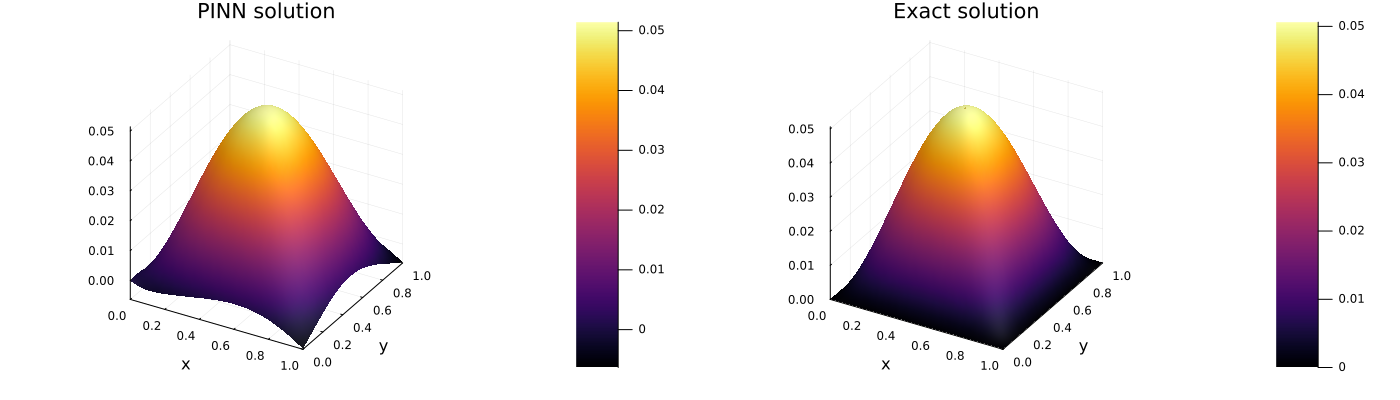

In [11]:
# Plot PINN vs exact and error
p1 = surface(xs, ys, u_pred; title="PINN solution", xlabel="x", ylabel="y")
p2 = surface(xs, ys, u_true; title="Exact solution", xlabel="x", ylabel="y")
plot(p1, p2; layout=(1,2), size=(1400,400))
#plot(p1, p2)    

**Heat map**

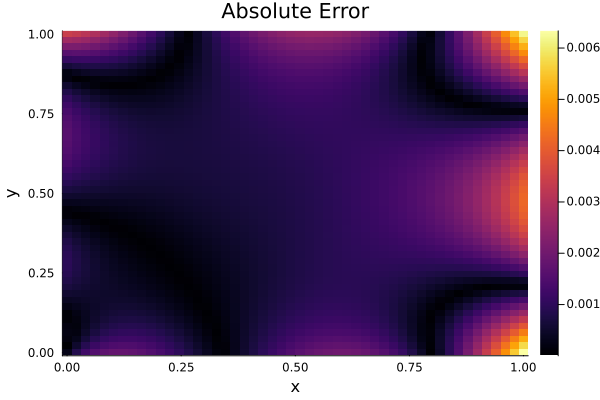

In [12]:
err = abs.(u_pred .- u_true)
heatmap(xs, ys, err; title="Absolute Error", xlabel="x", ylabel="y", colorbar=true)